In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [3]:
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

### Создадим агрегатор

In [4]:
from src.aggregate.base import Aggregator
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.merge import UnionMerger

In [5]:
N_CLASSES = 2
INTEGRATE_THRESHOLD = 1

In [6]:
classifier = ThresholdClassifier(N_CLASSES, INTEGRATE_THRESHOLD)
merger = UnionMerger(N_CLASSES)
aggregator = Aggregator(classifier, merger)

### Интерполированный тест

In [7]:
import pickle
import json
TEST_NAME = 'sparse'
with open(f'../../../groups/gt_test_{TEST_NAME}.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'../../../groups/pred_test_{TEST_NAME}.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/{TEST_NAME}_test/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

Median group size: 21


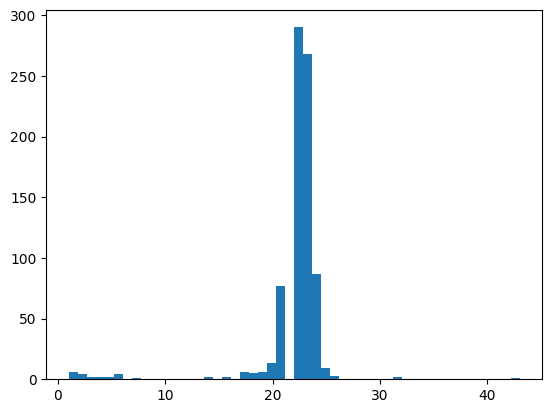

In [8]:
plt.hist([len(g) for g in gt_extended_groups], bins=50)
median_length = int(np.median([len(g) for g in pred_extended_groups]))
print(f"Median group size: {median_length}")

### Получим группы на ленте

In [9]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        obj['obj'] = shift_mask(obj['obj'], shift)
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [10]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [11]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

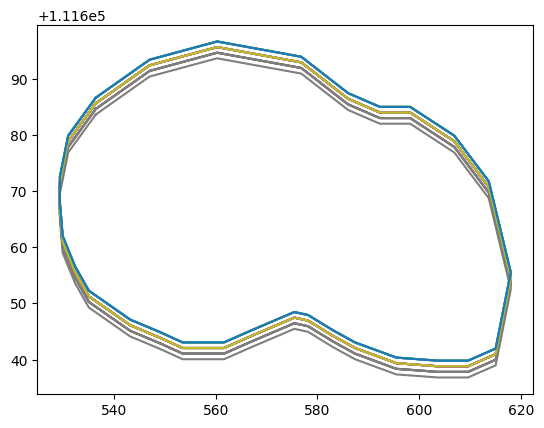

In [12]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Агрегация

In [13]:
gt = aggregator.aggregate(gt_groups)
pred = aggregator.aggregate(pred_groups)

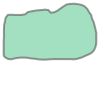

In [14]:
poly(gt[random.randint(0, len(gt))])

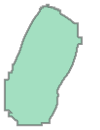

In [15]:
poly(pred[random.randint(0, len(pred))])

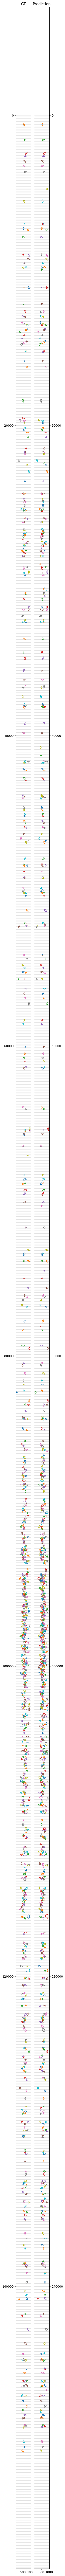

In [16]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, max(shifts.values()) / 1000))

for polygon in map(poly, gt):
    x, y = polygon.exterior.xy
    ax1.plot(x, y)
ax1.invert_yaxis()
ax1.set_title('GT')

for polygon in map(poly, pred):
    x, y = polygon.exterior.xy
    ax2.plot(x, y)
ax2.invert_yaxis()
ax2.set_title('Prediction')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

xlim = (min(ax.get_xlim()[0] for ax in [ax1, ax2]), max(ax.get_xlim()[1] for ax in [ax1, ax2]))
ylim = (min(ax.get_ylim()[0] for ax in [ax1, ax2]), max(ax.get_ylim()[1] for ax in [ax1, ax2]))

for ax in [ax1, ax2]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


min_ylim = 0
max_ylim = min(ax.get_ylim()[0] for ax in [ax1, ax2])
for ax in [ax1, ax2]:
    step = 100  # Draw line every 100 pixels
    for y in range(int(min_ylim), int(max_ylim), step):
        ax.axhline(y=y, color='gray', alpha=0.2, linestyle='-')

plt.show()

### Метрики

In [17]:
from tqdm import tqdm 

def boxes_intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check if one box is to the right of the other
    if x1 + w1 <= x2 or x2 + w2 <= x1:
        return False
        
    # Check if one box is above the other
    if y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
        
    return True

def find_matches(gt : list[dict], pred : list[dict], iou_threshold : float = 0.7):
    gt_boxes = [get_box(t) for t in gt]
    pred_boxes = [get_box(t) for t in pred]

    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)

    for i, gt_obj in tqdm(enumerate(gt), total=len(gt)):
        for j, pred_obj in enumerate(pred):
            if boxes_intersect(gt_boxes[i], pred_boxes[j]):
                iou = mask_iou(gt_obj, pred_obj)
                if iou > iou_threshold:
                    gt_matches[i] = True
                    pred_matches[j] = True
    return np.array(gt_matches), np.array(pred_matches)

In [18]:
gt_matches, pred_matches = find_matches(gt, pred)

  7%|▋         | 52/792 [00:00<00:04, 148.61it/s]

100%|██████████| 792/792 [00:40<00:00, 19.48it/s]


In [19]:
precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8055
Recall: 0.9040
F1 Score: 0.8519


### Оптимальный порог интеграции

In [20]:
def find_best_threshold(gt_aligned_groups, pred_aligned_groups):
    thresholds = range(1, median_length + 1)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        classifier = ThresholdClassifier(N_CLASSES, threshold)
        merger = UnionMerger(N_CLASSES)
        aggregator = Aggregator(classifier, merger)
        
        pred = aggregator.aggregate(pred_groups)

        gt_matches, pred_matches = find_matches(gt, pred)

        precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
        recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

100%|██████████| 792/792 [00:22<00:00, 34.62it/s] 


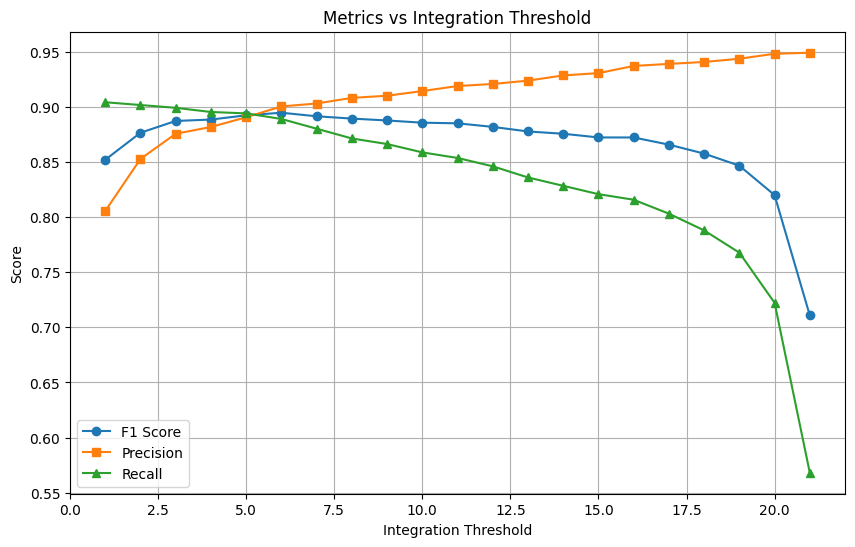

Max F1: 0.895 at threshold 6


In [21]:
find_best_threshold(gt_aligned_groups, pred_aligned_groups)

### Визуализация группы

In [22]:
iidx = 0
gidx = 20

In [23]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from utils.interpolate.markup_utils import vis_markup

for instance in pred_extended_groups[gidx][iidx:iidx+1]:
    print(instance['is_matched'], instance['is_border'], instance['img'])
    name = Path(instance['img']).name
    s = shifts[name] % 1000
    img = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs') / name)
    img = vis_markup(img, [instance['obj']])
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].set_title('Ground truth')
    axs[0].axis('off')
    axs[0].imshow(img)
    axs[0].axhline(y=img.shape[0]-s, color='r', linestyle='-')
    img_gt = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs') / name)
    img_gt = vis_markup(img_gt, [shift_mask(obj, -s) for obj in pred_groups[gidx]])
    axs[1].set_title('Predicted')
    axs[1].axis('off')
    axs[1].imshow(img_gt)
    axs[1].axhline(y=img_gt.shape[0]-s, color='r', linestyle='-')
    
    
iidx += 1
print(shifts[name])

plt.show()

False True runs/segment/predict/tula_sep_0002_2024_07_22_18_00_36_200.jpg


[ WARN:0@913.919] global loadsave.cpp:268 findDecoder imread_('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs/tula_sep_0002_2024_07_22_18_00_36_200.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
iidx = 0
gidx += 1

In [ ]:
gt_groups[gidx][0]

{'cls': '0',
 'points': array([[     335.91,      1293.4],
        [     335.91,      1292.2],
        [     330.92,      1287.2],
        [     330.92,      1285.9],
        [     329.66,      1284.7],
        [     312.19,      1284.7],
        [     310.94,      1285.9],
        [     309.69,      1285.9],
        [     308.44,      1287.2],
        [     307.19,      1287.2],
        [     305.94,      1288.4],
        [      304.7,      1288.4],
        [     303.45,      1289.7],
        [     300.95,      1289.7],
        [      299.7,      1290.9],
        [     295.95,      1290.9],
        [     292.22,      1294.7],
        [     292.22,      1300.9],
        [     292.29,        1301],
        [     343.48,        1301],
        [     335.91,      1293.4]], dtype=float32),
 'count': 1}

In [ ]:
shifts

{'tula_sep_0002_2024_07_16_14_17_15_000.jpg': 60,
 'tula_sep_0002_2024_07_16_14_17_15_200.jpg': 120,
 'tula_sep_0002_2024_07_16_14_17_15_400.jpg': 180,
 'tula_sep_0002_2024_07_16_14_17_15_600.jpg': 240,
 'tula_sep_0002_2024_07_16_14_17_15_800.jpg': 301,
 'tula_sep_0002_2024_07_16_14_17_16_000.jpg': 362,
 'tula_sep_0002_2024_07_16_14_17_16_200.jpg': 422,
 'tula_sep_0002_2024_07_16_14_17_16_400.jpg': 483,
 'tula_sep_0002_2024_07_16_14_17_16_600.jpg': 545,
 'tula_sep_0002_2024_07_16_14_17_16_800.jpg': 606,
 'tula_sep_0002_2024_07_16_14_17_17_000.jpg': 668,
 'tula_sep_0002_2024_07_16_14_17_17_200.jpg': 729,
 'tula_sep_0002_2024_07_16_14_17_17_400.jpg': 789,
 'tula_sep_0002_2024_07_16_14_17_17_600.jpg': 851,
 'tula_sep_0002_2024_07_16_14_17_17_800.jpg': 912,
 'tula_sep_0002_2024_07_16_14_17_18_000.jpg': 974,
 'tula_sep_0002_2024_07_16_14_17_18_200.jpg': 1036,
 'tula_sep_0002_2024_07_16_14_17_18_400.jpg': 1097,
 'tula_sep_0002_2024_07_16_14_17_18_600.jpg': 1159,
 'tula_sep_0002_2024_07_16_14

In [ ]:
shifts['tula_sep_0002_2024_07_16_14_17_15_600.jpg']

240